In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt

# 1.1 Baseline Setup


#### 1. Configurations


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
num_epochs = 5
learning_rate = 0.001

#### 2. CIFAR-10 Dataset


In [4]:
transform = transforms.Compose([
    transforms.Resize(224),   # ResNet expects 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = trainset.classes


100%|██████████| 170M/170M [00:12<00:00, 13.1MB/s]


#### 3. Load Pre-trained ResNet-152 + Loss and Optimizer


In [5]:
model = models.resnet152(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final classification layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)  # CIFAR-10 has 10 classes

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


100%|██████████| 230M/230M [00:01<00:00, 181MB/s]


#### 4. Training Loop


In [8]:
train_acc_hist, val_acc_hist = [], []

for epoch in range(num_epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0.0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    train_acc_hist.append(train_acc)

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    val_acc_hist.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

Epoch [1/5], Train Acc: 83.10%, Val Acc: 82.72%
Epoch [2/5], Train Acc: 83.29%, Val Acc: 84.23%
Epoch [3/5], Train Acc: 83.66%, Val Acc: 84.97%
Epoch [4/5], Train Acc: 83.75%, Val Acc: 85.23%
Epoch [5/5], Train Acc: 84.14%, Val Acc: 83.81%


#### 5. Plot Results


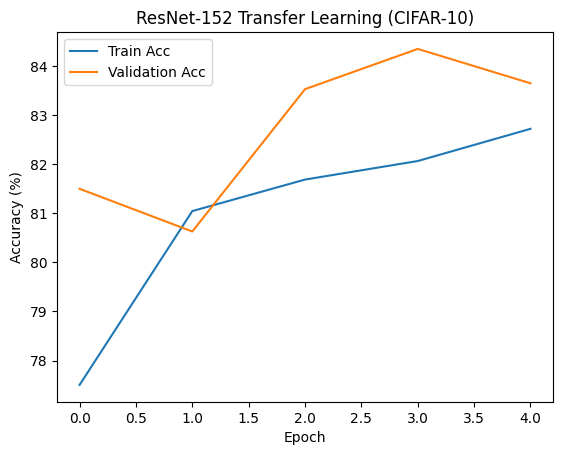

In [7]:
plt.plot(train_acc_hist, label='Train Acc')
plt.plot(val_acc_hist, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('ResNet-152 Transfer Learning (CIFAR-10)')
plt.show()